In [19]:
import numpy as np
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
import hvplot.pandas 
import matplotlib.pyplot as plt

from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from holoviews import opts, Layout, dim
import holoviews as hv

import warnings
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=500, frame_height=400))
aggregatorOpts = { 'max_distance':1000, 'min_distance':100, 'min_stop_duration':timedelta(minutes=1)}

Load Filtered Sample

In [20]:
filtered_sample = pd.read_csv('./train_filtered_sample.csv')
filtered_sample['geometry'] = filtered_sample[['lng', 'lat',]].apply(Point, axis=1)

In [21]:
filtered_sample['WEEK_DAY'] = filtered_sample.datetime.apply(lambda x: datetime.fromisoformat(x).weekday())
filtered_sample['YEAR'] = filtered_sample.datetime.apply(lambda x: datetime.fromisoformat(x).year)
filtered_sample['MONTH'] = filtered_sample.datetime.apply(lambda x: datetime.fromisoformat(x).month)
filtered_sample['MONTH_DAY'] = filtered_sample.datetime.apply(lambda x: datetime.fromisoformat(x).day)
filtered_sample['HOUR'] = filtered_sample.datetime.apply(lambda x: datetime.fromisoformat(x).hour)
filtered_sample['DATE'] = filtered_sample.datetime.apply(lambda x: datetime.fromisoformat(x).date().isoformat())
filtered_sample['DATE_DATE'] = filtered_sample.datetime.apply(lambda x: datetime.fromisoformat(x).date())

**Q0: Qual a maior velocidade registrada?**

In [22]:
sample_gdf = gpd.GeoDataFrame(filtered_sample, crs='WGS84')
sample_tc = mpd.TrajectoryCollection(sample_gdf, obj_id_col='uid', traj_id_col='trip_id', t='datetime', x='lng', y='lat')
sample_tc.add_speed(overwrite=True)

In [23]:
max_speed = sample_tc.get_max('speed')
print('Maior velocidade registrada é {:,.2f} km/h'.format(max_speed*3600/1000))

Maior velocidade registrada é 159.65 km/h


**Q1: O número de viajens está distribuido no tempo?**

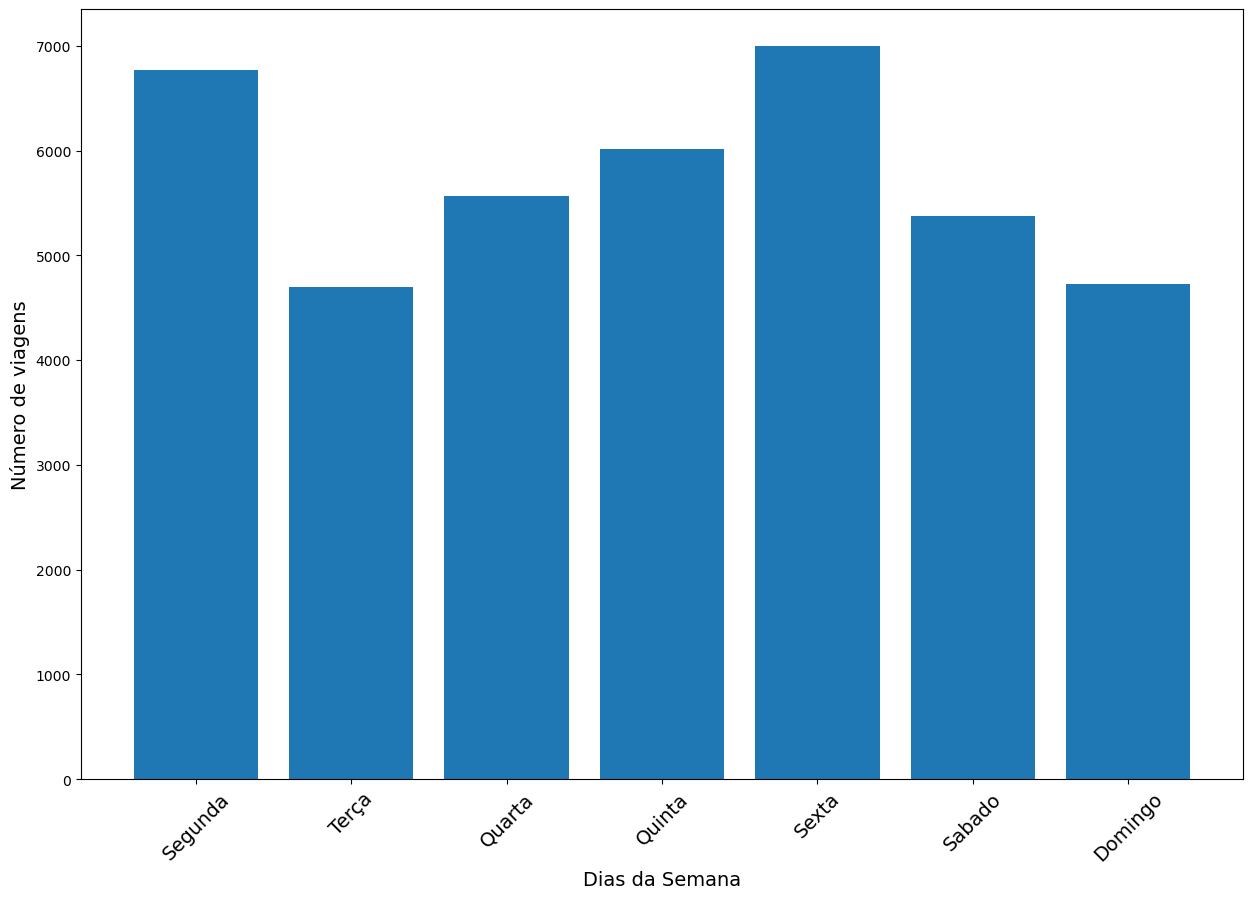

In [24]:
keys_week = np.arange(0,7)
values_week = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sabado', 'Domingo']
week_days_names = dict(zip(keys_week,values_week))

plt.figure(figsize=(15,10))
ax = plt.bar(filtered_sample.WEEK_DAY.value_counts().keys()
        , filtered_sample.WEEK_DAY.map(week_days_names).value_counts().values)

plt.xticks(filtered_sample.WEEK_DAY.value_counts().keys()
           , filtered_sample.WEEK_DAY.map(week_days_names).value_counts().keys()
           , rotation = 45
           , size = 14)
plt.xlabel('Dias da Semana', size = 14)
plt.ylabel('Número de viagens', size = 14)
plt.show()

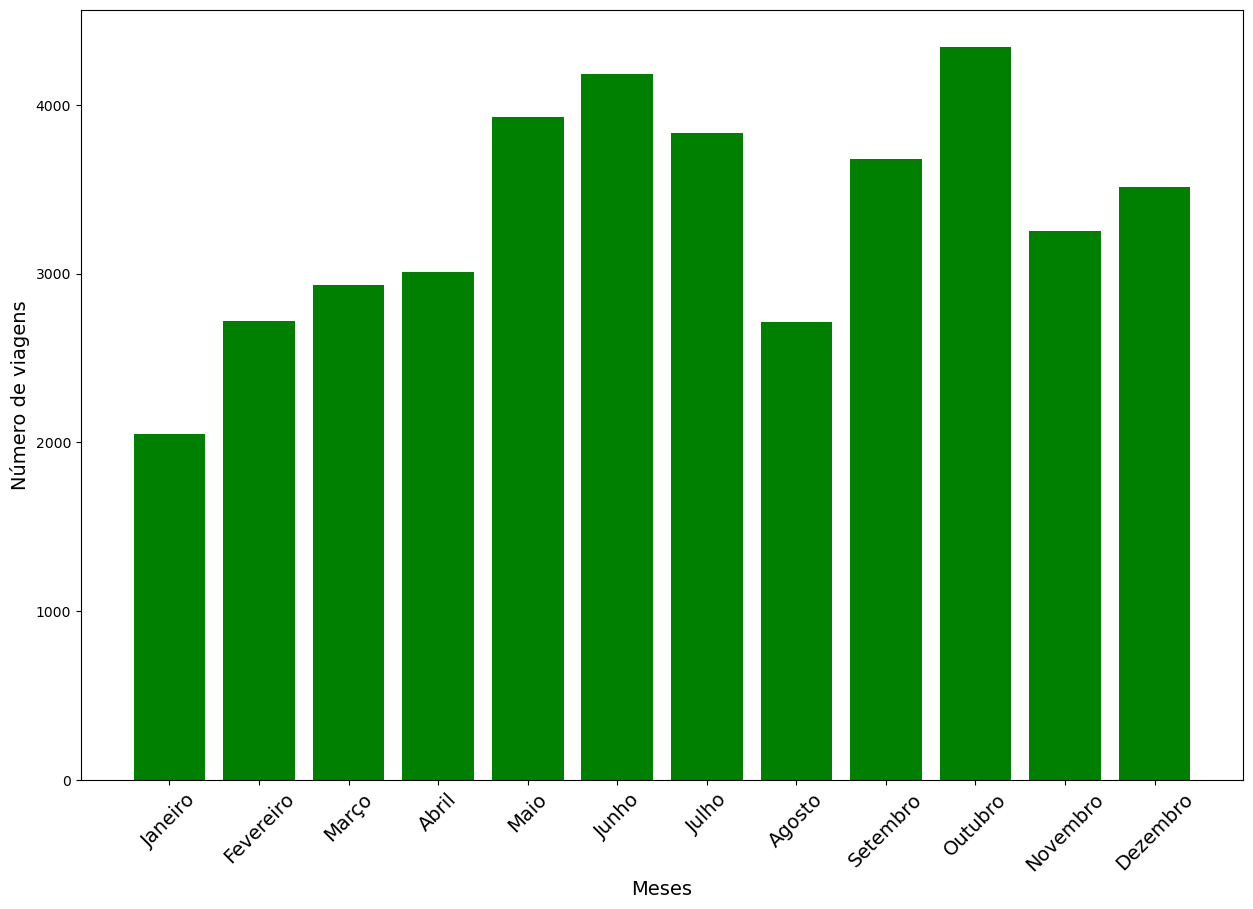

In [25]:
chaves_mes = np.arange(1,13)
nomes_mes = ['Janeiro','Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
nomes_dos_meses = dict(zip(chaves_mes, nomes_mes))

plt.figure(figsize=(15,10))
minhas_cores = 'g'
ax = plt.bar(filtered_sample.MONTH.value_counts().keys()
        , filtered_sample.MONTH.value_counts().values
        , color = minhas_cores)
plt.xticks(filtered_sample.MONTH.value_counts().keys()
           , filtered_sample.MONTH.map(nomes_dos_meses).value_counts().keys()
           , rotation = 45
           , size = 14)
plt.xlabel('Meses', size = 14)
plt.ylabel('Número de viagens', size = 14)
plt.show()

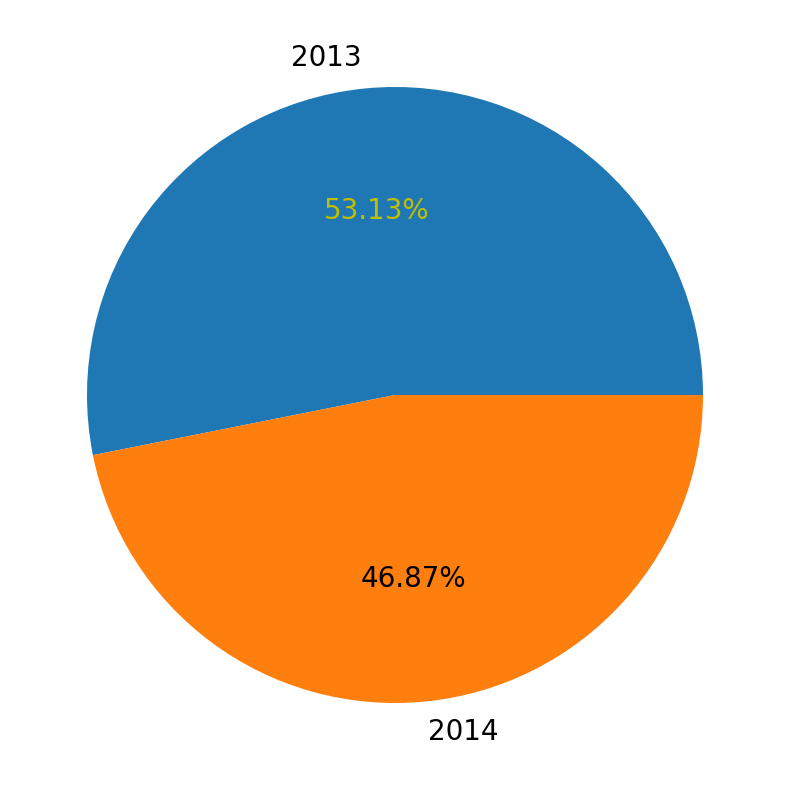

In [26]:
plt.figure(figsize=(10,10))
patches, texts, autotexts = plt.pie(filtered_sample.YEAR.value_counts().values
        , labels=filtered_sample.YEAR.value_counts().keys()
        , autopct='%1.2f%%')

for t in texts:
    t.set_fontsize(20)
for t in autotexts:
    t.set_fontsize(20)
autotexts[0].set_color('y')
plt.show()

**Q2: Onde ficam os pontos mais significantes, os agrupamentos com maior densidade e qual o fluxo entre eles?**

In [29]:
sample_gdf = gpd.GeoDataFrame(filtered_sample, crs='WGS84')
sample_tc = mpd.TrajectoryCollection(sample_gdf, obj_id_col='uid', traj_id_col='trip_id', t='datetime', x='lng', y='lat')
traj_aggregation =  mpd.TrajectoryCollectionAggregator(sample_tc, **aggregatorOpts)
flows = traj_aggregation.get_flows_gdf()
clusters = traj_aggregation.get_clusters_gdf()
plot = (
    flows.hvplot(geo=True, hover_cols=['weight'], line_width=dim('weight')/5, color='#68a7c6', tiles='CartoLight') *
    clusters.hvplot(geo=True, c='n', size=dim('n')/50, cmap='Oranges')
)
plot

ImportError: Geographic projection support requires: cartopy, geoviews.

**Q3: Existe uma lacuna expacial nos dados de mobilidade?**

In [ ]:
print(f'A amostra começa em {filtered_sample["datetime"].min()} e termina em {filtered_sample["datetime"].max()}')

A amostra começa em 2013-07-01 05:55:41 e termina em 2014-06-30 09:22:04


In [ ]:
sample_gdf = gpd.GeoDataFrame(filtered_sample, crs='WGS84')
# set datetime as index
sample_gdf = sample_gdf.to_crs({'init': 'epsg:4326'})
sample_gdf['datetime'] = sample_gdf['datetime'].astype('datetime64[ms]')
sample_gdf = sample_gdf.set_index('datetime')

In [ ]:
sample_gdf.resample('D').count().hvplot(title='Número de pontos por dia.')

:NdOverlay   [Variable]
   :Curve   [datetime]   (value)

**Q4: A Densidade e fluxos de mobilidade mudam durante os dias da semana?**

In [ ]:
sample_gdf = gpd.GeoDataFrame(filtered_sample, crs='WGS84')
# set datetime as index
sample_gdf = sample_gdf.to_crs({'init': 'epsg:4326'})
sample_gdf['datetime'] = sample_gdf['datetime'].astype('datetime64[ms]')
sample_gdf = sample_gdf.set_index('datetime')
# plot moviment cluster e flows for each day of week
plots = []
for i, day_name in enumerate(sample_gdf.index.day_name().unique()):
    data_day_of_week = sample_gdf[sample_gdf.index.day_name() == day_name]
    tc_in_day_of_week = mpd.TrajectoryCollection(data_day_of_week, obj_id_col='uid', traj_id_col='trip_id', t='datetime', x='lng', y='lat')
    traj_aggregation =  mpd.TrajectoryCollectionAggregator(tc_in_day_of_week, **aggregatorOpts)
    flows = traj_aggregation.get_flows_gdf()
    clusters = traj_aggregation.get_clusters_gdf()
    plot = (
        flows.hvplot(geo=True, hover_cols=['weight'], line_width=dim('weight'), color='#68a7c6', tiles='CartoLight') *
        clusters.hvplot(geo=True, c='n', size=dim('n')/5, title=day_name, cmap='Oranges')
    )
    plots.append(plot)
Layout(plots)

:Layout
   .Overlay.I   :Overlay
      .Tiles.I  :Tiles   [x,y]
      .Path.I   :Path   [Longitude,Latitude]   (weight)
      .Points.I :Points   [Longitude,Latitude]   (n)
   .Overlay.II  :Overlay
      .Tiles.I  :Tiles   [x,y]
      .Path.I   :Path   [Longitude,Latitude]   (weight)
      .Points.I :Points   [Longitude,Latitude]   (n)
   .Overlay.III :Overlay
      .Tiles.I  :Tiles   [x,y]
      .Path.I   :Path   [Longitude,Latitude]   (weight)
      .Points.I :Points   [Longitude,Latitude]   (n)
   .Overlay.IV  :Overlay
      .Tiles.I  :Tiles   [x,y]
      .Path.I   :Path   [Longitude,Latitude]   (weight)
      .Points.I :Points   [Longitude,Latitude]   (n)
   .Overlay.V   :Overlay
      .Tiles.I  :Tiles   [x,y]
      .Path.I   :Path   [Longitude,Latitude]   (weight)
      .Points.I :Points   [Longitude,Latitude]   (n)
   .Overlay.VI  :Overlay
      .Tiles.I  :Tiles   [x,y]
      .Path.I   :Path   [Longitude,Latitude]   (weight)
      .Points.I :Points   [Longitude,Latitude]   (n)
   .Overlay.VII :Overlay
      .Tiles.I  :Tiles   [x,y]
      .Path.I   :Path   [Longitude,Latitude]   (weight)
      .Points.I :Points   [Longitude,Latitude]   (n)